# What is RNN?

<img src="simple_rnn.png" alt="Drawing" style="width: 500px;"/>

In [2]:
from swat import *
from datetime import datetime
import os
from pprint import pprint
try:
    from StringIO import StringIO
except:
    from io import StringIO
import swat.cas.datamsghandlers as dmh

host = 'dlgrd008'

s = CAS(host, 32513, 'nijinz')
s.sessionprop.setsessopt(caslib='CASUSER')
s.loadactionset('deepLearn')
s.loadactionset('castmine')
s.loadactionset('fedsql')

NOTE: 'CASUSER(nijinz)' is now the active caslib.
NOTE: Added action set 'deepLearn'.
NOTE: Added action set 'castmine'.
NOTE: Added action set 'fedsql'.


[actionset]

 'fedsql'

+ Elapsed: 0.00966s, sys: 0.00106s, mem: 0.25mb

In [5]:
s.upload('/dept/cas/nijinz/time_series_data/rnn_raleigh_weather_train_dated.csv', casout=dict(name='training', replace=True),
          importoptions=dict(fileType='csv', getnames=True))
s.upload('/dept/cas/nijinz/time_series_data/rnn_raleigh_weather_dev_dated.csv', casout=dict(name='validation', replace=True),
          importoptions=dict(fileType='csv', getnames=True))
s.upload('/dept/cas/nijinz/time_series_data/rnn_raleigh_weather_test_dated.csv', casout=dict(name='testing', replace=True),
          importoptions=dict(fileType='csv', getnames=True))

NOTE: Cloud Analytic Services made the uploaded file available as table TRAINING in caslib CASUSER(nijinz).
NOTE: The table TRAINING has been created in caslib CASUSER(nijinz) from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table VALIDATION in caslib CASUSER(nijinz).
NOTE: The table VALIDATION has been created in caslib CASUSER(nijinz) from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table TESTING in caslib CASUSER(nijinz).
NOTE: The table TESTING has been created in caslib CASUSER(nijinz) from binary data uploaded to Cloud Analytic Services.


[caslib]

 'CASUSER(nijinz)'

[tableName]

 'TESTING'

[casTable]

 CASTable('TESTING', caslib='CASUSER(nijinz)')

+ Elapsed: 0.0491s, user: 0.0665s, sys: 0.0198s, mem: 117mb

# What's In the Table

In [8]:
columns = s.columninfo('testing')['ColumnInfo']['Column']
print(','.join(columns[1:14]))
s.fetch('testing', to=5)

TEMP_1,STP_1,VISIB_1,WDSP_1,MXSPD_1,MAX_1,MIN_1,FOG_1,RAIN_1,SNOW_1,HAIL_1,THUNDER_1,TORNADO_1


,DATE,TEMP_1,STP_1,VISIB_1,WDSP_1,MXSPD_1,MAX_1,MIN_1,FOG_1,RAIN_1,...,WDSP_8,MXSPD_8,MAX_8,MIN_8,FOG_8,RAIN_8,SNOW_8,HAIL_8,THUNDER_8,TORNADO_8
0,2015-06-19,81.0,1001.2,8.5,5.3,14.0,98.1,71.1,0.0,1.0,...,3.6,11.1,91.9,71.1,0.0,1.0,0.0,0.0,1.0,0.0
1,2014-08-03,70.8,1003.4,8.6,1.0,7.0,80.1,64.0,0.0,0.0,...,5.3,9.9,81.0,64.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2011-12-14,48.3,1012.9,10.0,1.0,5.1,63.0,31.1,0.0,0.0,...,7.0,17.1,64.9,55.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2012-08-22,73.4,1002.9,8.0,2.4,8.9,82.0,69.1,0.0,1.0,...,4.1,9.9,87.1,72.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2012-03-19,63.0,1006.7,6.6,1.4,9.9,77.0,53.1,1.0,1.0,...,3.7,8.9,77.0,55.9,0.0,1.0,0.0,0.0,0.0,0.0


In [82]:
s.summary(table='testing', inputs=['TEMP_1', 'STP_1', 'WDSP_1'])['Summary'][['Column', 'Min', 'Max', 'Mean', 'Var']]

,Column,Min,Max,Mean,Var
0,TEMP_1,15.0,90.4,61.373762,238.776253
1,STP_1,977.2,1024.3,1002.158398,36.239116
2,WDSP_1,0.1,15.5,4.926238,6.441348


# Building a Temperature Forecasting Model

In [9]:
inputs = list(s.columninfo('testing')['ColumnInfo']['Column'][1:(13*7+1)])
print(inputs)

['TEMP_1', 'STP_1', 'VISIB_1', 'WDSP_1', 'MXSPD_1', 'MAX_1', 'MIN_1', 'FOG_1', 'RAIN_1', 'SNOW_1', 'HAIL_1', 'THUNDER_1', 'TORNADO_1', 'TEMP_2', 'STP_2', 'VISIB_2', 'WDSP_2', 'MXSPD_2', 'MAX_2', 'MIN_2', 'FOG_2', 'RAIN_2', 'SNOW_2', 'HAIL_2', 'THUNDER_2', 'TORNADO_2', 'TEMP_3', 'STP_3', 'VISIB_3', 'WDSP_3', 'MXSPD_3', 'MAX_3', 'MIN_3', 'FOG_3', 'RAIN_3', 'SNOW_3', 'HAIL_3', 'THUNDER_3', 'TORNADO_3', 'TEMP_4', 'STP_4', 'VISIB_4', 'WDSP_4', 'MXSPD_4', 'MAX_4', 'MIN_4', 'FOG_4', 'RAIN_4', 'SNOW_4', 'HAIL_4', 'THUNDER_4', 'TORNADO_4', 'TEMP_5', 'STP_5', 'VISIB_5', 'WDSP_5', 'MXSPD_5', 'MAX_5', 'MIN_5', 'FOG_5', 'RAIN_5', 'SNOW_5', 'HAIL_5', 'THUNDER_5', 'TORNADO_5', 'TEMP_6', 'STP_6', 'VISIB_6', 'WDSP_6', 'MXSPD_6', 'MAX_6', 'MIN_6', 'FOG_6', 'RAIN_6', 'SNOW_6', 'HAIL_6', 'THUNDER_6', 'TORNADO_6', 'TEMP_7', 'STP_7', 'VISIB_7', 'WDSP_7', 'MXSPD_7', 'MAX_7', 'MIN_7', 'FOG_7', 'RAIN_7', 'SNOW_7', 'HAIL_7', 'THUNDER_7', 'TORNADO_7']


In [81]:
init = 'xavier'
n = 16
s.buildmodel(model=dict(name='reg_temp', replace=True), type='RNN')
s.addlayer(model='reg_temp', name='data', layer=dict(type='input', std='std'))
s.addlayer(model='reg_temp', name='rnn1', srclayers=['data'],
           layer=dict(type='recurrent',n=n,init=init,rnnType='GRU',outputType='samelength'))
s.addlayer(model='reg_temp', name='rnn2', srclayers=['rnn1'],
           layer=dict(type='recurrent',n=n,init=init,rnnType='GRU',outputType='samelength'))
s.addlayer(model='reg_temp', name='rnn3', srclayers=['rnn2'],
           layer=dict(type='recurrent',n=n,init=init,rnnType='GRU',outputType='samelength'))
s.addlayer(model='reg_temp', name='rnn4', srclayers=['rnn3'],
           layer=dict(type='recurrent',n=n,init=init,rnnType='GRU',outputType='encoding'))
s.addlayer(model='reg_temp', name='outlayer', srclayers=['rnn4'],
           layer=dict(type='output', act='identity', targetstd='std'))

,casLib,Name,Rows,Columns,casTable
0,CASUSER(nijinz),reg_temp,74,5,"CASTable('reg_temp', caslib='CASUSER(nijinz)')"


# Training the Model

In [80]:
# fit error is MSE, loss is 0.5*MSE
r = s.dlTrain(table='training', model='reg_temp', validTable='validation',
              modelWeights=dict(name='trainedWeights', replace=True),
              bestWeights=dict(name='bestTrainedWeights', replace=True),
              target='TEMP_8', inputs=inputs,
              sequenceOpts=dict(tokensize=13),
              optimizer=dict(miniBatchSize=4, maxEpochs=50,
                             regl2=0.0001,
                             algorithm=dict(method='adam', beta1=0.9, beta2=0.999, gamma=0.5, learningRate=0.01,
                                            clipGradMax=1000, clipGradMin=-1000, stepSize=15, lrPolicy='step'
                                           )
                            ),
              seed=32513
           )
r['OutputCasTables']

,casLib,Name,Rows,Columns,casTable
0,CASUSER(nijinz),bestTrainedWeights,6209,3,"CASTable('bestTrainedWeights', caslib='CASUSER..."
1,CASUSER(nijinz),trainedWeights,6209,3,"CASTable('trainedWeights', caslib='CASUSER(nij..."


# Scoring

In [14]:
# fit error is MSE, loss is 0.5*MSE with standardized values
s.dlScore(table='testing', model='reg_temp', initWeights='bestTrainedWeights', copyVars=['date', 'temp_8'],
          casout=dict(name='forecast_out', replace=True))

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read          2584
 1  Number of Observations Used          2584
 2           Mean Squared Error       24.2098
 3                   Loss Error      0.050719

[OutputCasTables]

             casLib          Name  Rows  Columns  \
 0  CASUSER(nijinz)  forecast_out  2584        3   
 
                                             casTable  
 0  CASTable('forecast_out', caslib='CASUSER(nijin...  

+ Elapsed: 0.027s, user: 0.0577s, sys: 0.261s, mem: 125mb

# Comparison with Ground Truth (Jan-Mar 2017)

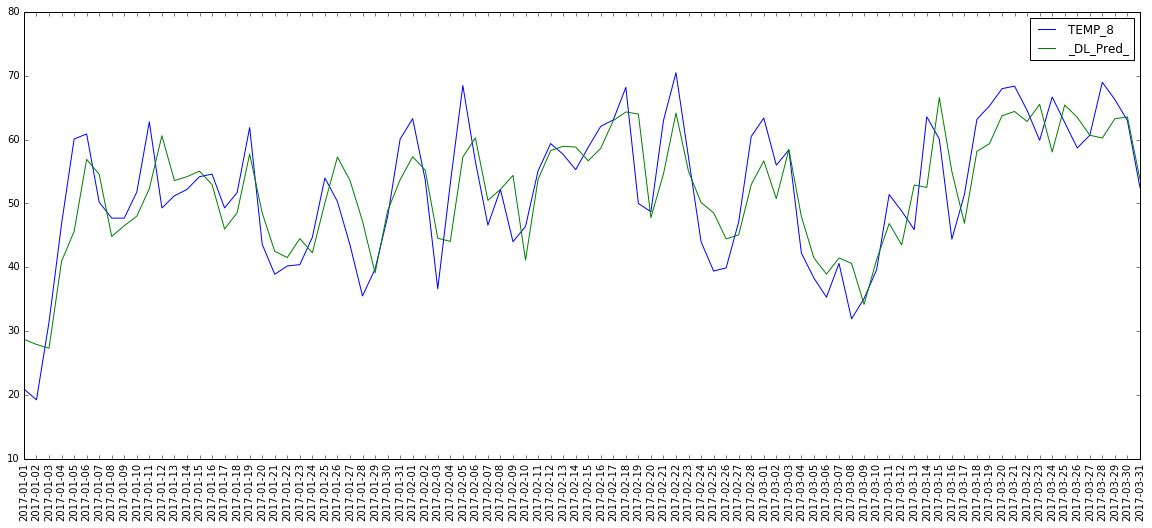

In [79]:
# only one clear lagging near end of Jan
%matplotlib inline
df = s.fetch(table=dict(name='forecast_out', where='date>="2017-01-01" and date<"2017-04-01"'),
             to=5000,maxrows=5000, orderby='DATE')['Fetch']
ax = df.plot(figsize=(20,8), xticks=df.index)
ret = ax.set_xticklabels(df['DATE'], rotation=90)

# Comparison with Ground Truth (Jul-Sep 2017, Hurricanes Harvey and Irma)

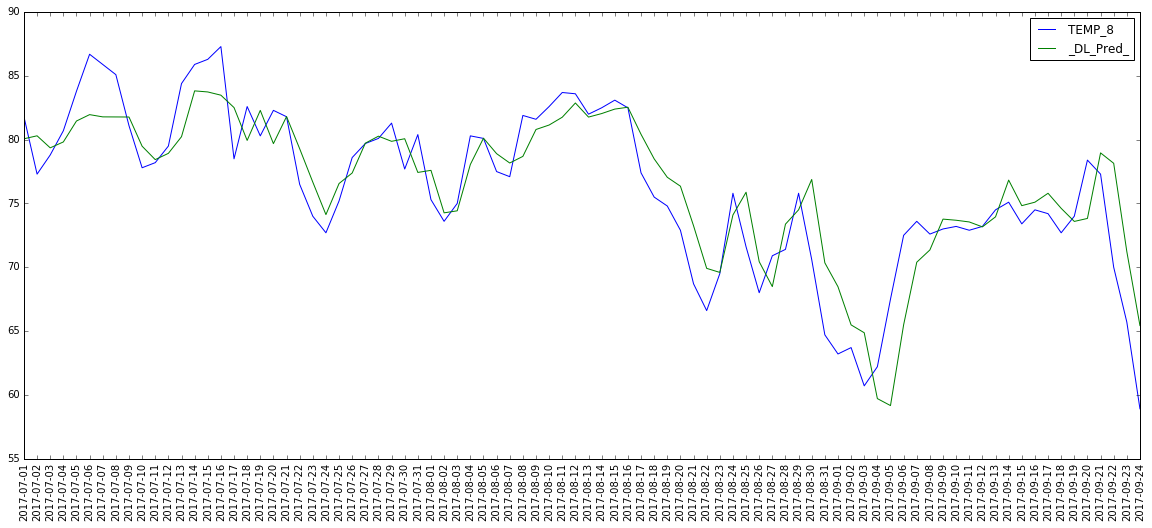

In [70]:
# hurricane Harvey and Irma in late August and early to mid September
%matplotlib inline
df = s.fetch(table=dict(name='forecast_out', where='date>="2017-07-01"'),to=5000,maxrows=5000, orderby='DATE')['Fetch']
ax = df.plot(figsize=(20,8), xticks=df.index)
ret = ax.set_xticklabels(df['DATE'], rotation=90)